In [8]:
#Run in Colab or with GPU

#Load data:
#icml_face_data-edited.csv
#Shawon.jpg
#wallpaper2you_443897.jpg
#20230413_120155.jpg
#20230413_120157.jpg
#20230413_120159.jpg
#20230425_122026.jpg
#model2_filter.h5

#NOTE: The dataset used here is slightly modified from the original dataset in that columns two and three are flipped. So in 
#this edited version, column pixels comes before the usage column.

In [9]:
#Install/import packages
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from skimage import io
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
import math
from sklearn.metrics import RocCurveDisplay
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# get the data
filename = 'icml_face_data-edited.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('icml_face_data-edited.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [11]:
def getData(filename):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    #X, Y = np.array(X)/255, np.array(Y)
    X, Y = np.array(X), np.array(Y)
    X = X/255
    #return X[:2], Y[:2]
    return X, Y

In [12]:
X, Y = getData(filename)
print(X[1])
print(Y[1])
num_class = len(set(Y))
print(num_class)

[0.59215686 0.58823529 0.57647059 ... 0.75686275 0.71764706 0.72156863]
0
7


In [13]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [14]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [15]:
def my_model():
  # Initialising the CNN
  model = Sequential()

  # 1st - Convolution layer
  model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 2nd Convolution layer
  model.add(Conv2D(128,(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 3rd Convolution layer
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 4th Convolution layer
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # Flattening
  model.add(Flatten())

  # Fully connected layer 1st layer
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  # Fully connected layer 2nd layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))

  opt = Adam(lr=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
#Model
path_model='model2_filter.h5'

tf.keras.backend.clear_session()
model=my_model()
tf.keras.backend.set_value(model.optimizer.lr,1e-3)

#fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/20
449/449 [==============================] - 27s 37ms/step - loss: 1.7550 - accuracy: 0.3231 - val_loss: 2.0108 - val_accuracy: 0.2608
Epoch 2/20
449/449 [==============================] - 16s 36ms/step - loss: 1.3871 - accuracy: 0.4728 - val_loss: 1.2561 - val_accuracy: 0.5152
Epoch 3/20
449/449 [==============================] - 16s 36ms/step - loss: 1.2480 - accuracy: 0.5198 - val_loss: 1.3716 - val_accuracy: 0.4827
Epoch 4/20
449/449 [==============================] - 16s 35ms/step - loss: 1.1746 - accuracy: 0.5520 - val_loss: 1.1998 - val_accuracy: 0.5414
Epoch 5/20
449/449 [==============================] - 16s 36ms/step - loss: 1.1124 - accuracy: 0.5759 - val_loss: 1.3519 - val_accuracy: 0.4727
Epoch 6/20
449/449 [==============================] - 17s 37ms/step - loss: 1.0618 - accuracy: 0.5946 - val_loss: 1.1741 - val_accuracy: 0.5483
Epoch 7/20
449/449 [==============================] - 16s 36ms/step - loss: 1.0188 - accuracy: 0.6146 - val_loss: 1.1313 - val_accuracy:

In [17]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [18]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [19]:
y_pred=model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
print(y_pred[:1,:])
print(y_test[:1,:])

225/225 [==============================] - 2s 5ms/step
(7178, 7)
(7178, 7)
[[1.8457886e-02 1.4550499e-04 6.8887445e-04 8.8569176e-01 3.9577752e-02
  9.1817514e-05 5.5346362e-02]]
[[0. 0. 0. 1. 0. 0. 0.]]


1/1 [==============================] - 0s 128ms/step


/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


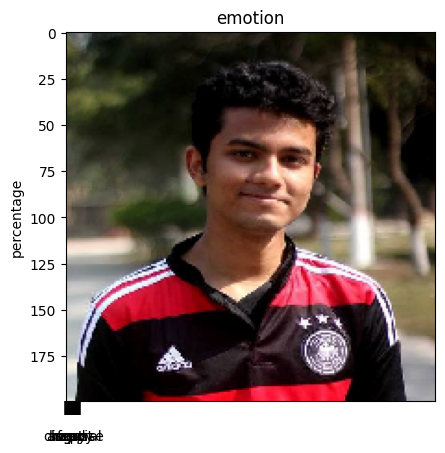

Expression Prediction: sad


In [20]:
img = image.load_img('Shawon.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Shawon.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 38ms/step


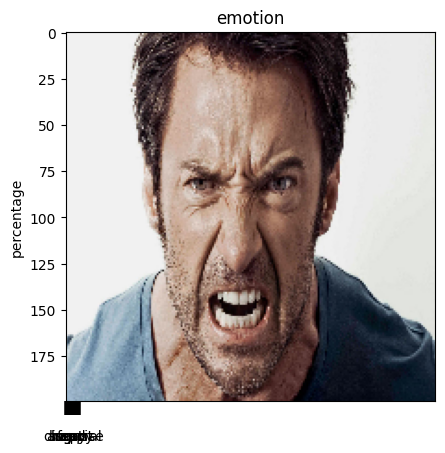

Expression Prediction: sad


In [21]:
img = image.load_img('wallpaper2you_443897.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('wallpaper2you_443897.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 29ms/step


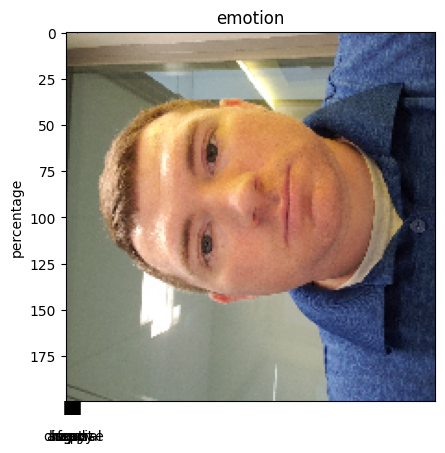

Expression Prediction: neutral


In [22]:
#ME1
img = image.load_img('20230413_120155.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('20230413_120155.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 27ms/step


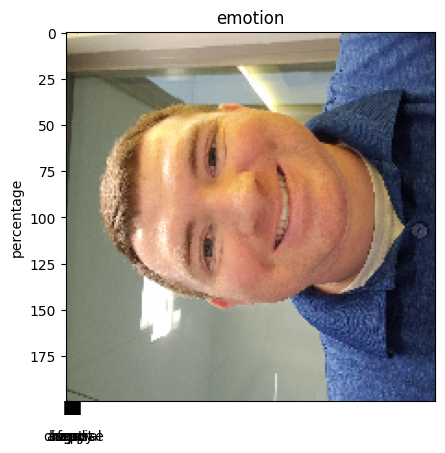

Expression Prediction: neutral


In [23]:
#ME2
img = image.load_img('20230413_120157.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('20230413_120157.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 29ms/step


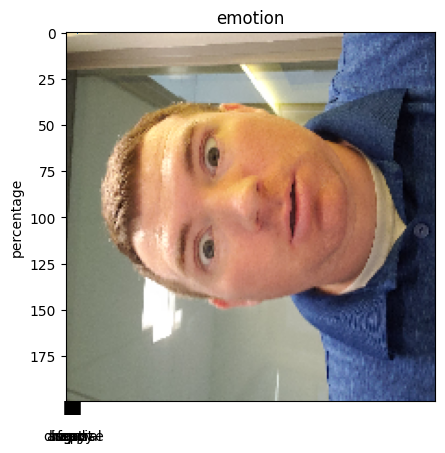

Expression Prediction: neutral


In [24]:
#ME3
img = image.load_img('20230413_120159.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('20230413_120159.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 20ms/step


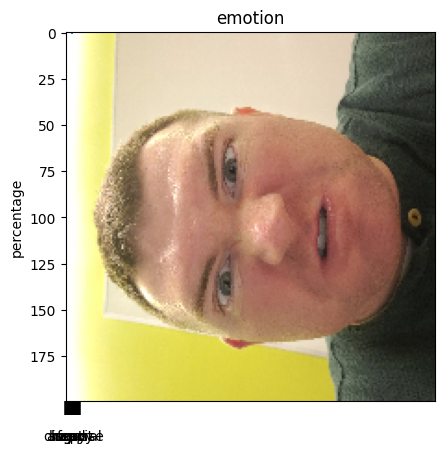

Expression Prediction: happy


In [25]:
#ME4
img = image.load_img('20230425_122026.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('20230425_122026.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [26]:
print(type(y_pred))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
y_pred_rounded = np.around(y_pred)
print(y_pred_rounded.shape)

(7178, 7)


In [28]:
#Accuracy score
accuracy = accuracy_score(y_test, y_pred_rounded)
accuracy

0.5707718027305656

In [29]:
#Validation Accuracy
path_checkpoint = "model2_filter.h5"
model.load_weights(path_checkpoint)
scores = model.evaluate(X_test, y_test, verbose=0)
print("\n Best validation accuracy: %.2f%%" % (scores[1]*100))


 Best validation accuracy: 60.38%


In [30]:
#Confusion Matrix
cm = multilabel_confusion_matrix(y_test, y_pred_rounded)

for i in range(len(cm)):
    print(f'Confusion matrix for label {i}:')
    print(cm[i])

Confusion matrix for label 0:
[[5884  333]
 [ 486  475]]
Confusion matrix for label 1:
[[7069    3]
 [  63   43]]
Confusion matrix for label 2:
[[5877  295]
 [ 646  360]]
Confusion matrix for label 3:
[[5213  128]
 [ 552 1285]]
Confusion matrix for label 4:
[[4897 1020]
 [ 458  803]]
Confusion matrix for label 5:
[[6241  138]
 [ 204  595]]
Confusion matrix for label 6:
[[5628  342]
 [ 672  536]]


Confusion matrix for label 0:
[[5884  333]
 [ 486  475]]


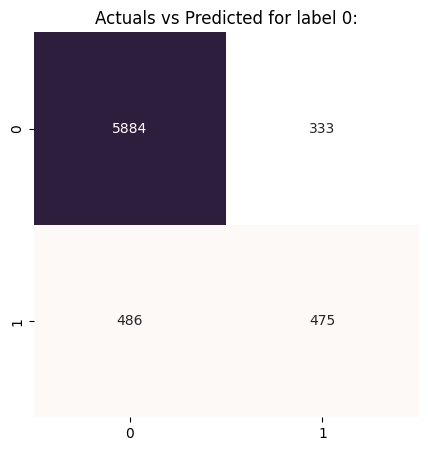

Confusion matrix for label 1:
[[7069    3]
 [  63   43]]


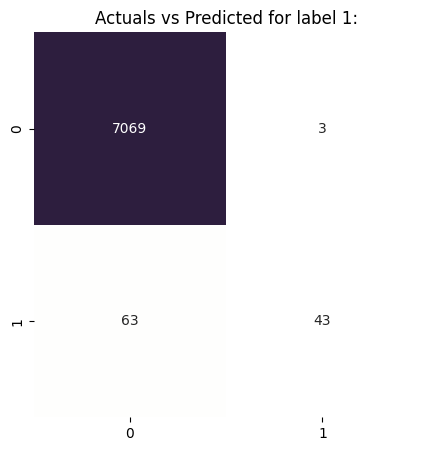

Confusion matrix for label 2:
[[5877  295]
 [ 646  360]]


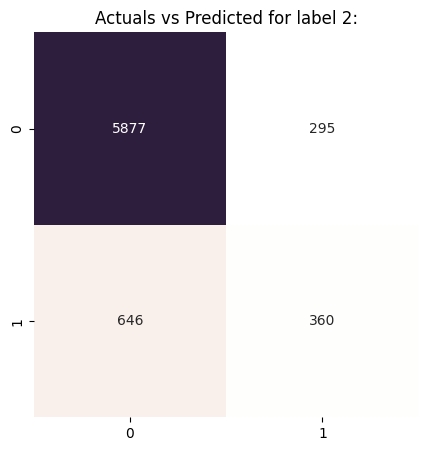

Confusion matrix for label 3:
[[5213  128]
 [ 552 1285]]


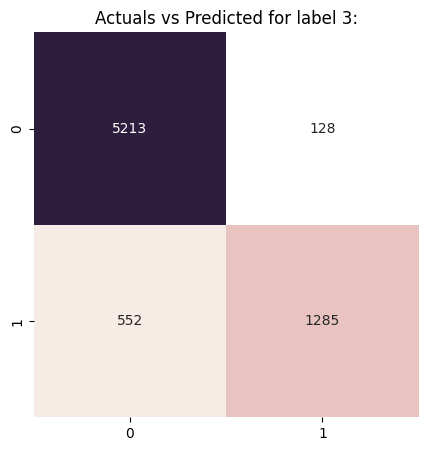

Confusion matrix for label 4:
[[4897 1020]
 [ 458  803]]


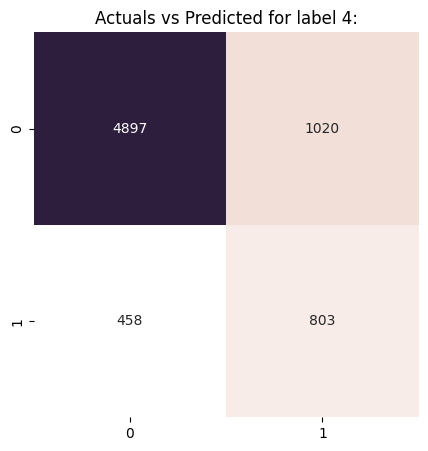

Confusion matrix for label 5:
[[6241  138]
 [ 204  595]]


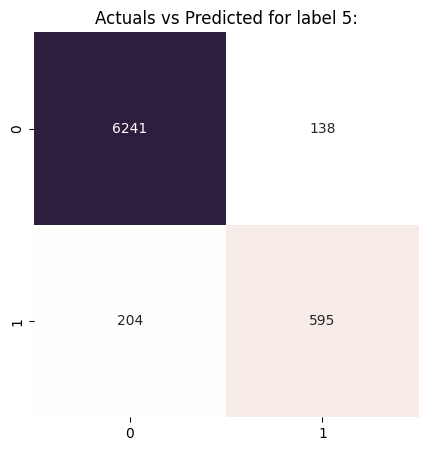

Confusion matrix for label 6:
[[5628  342]
 [ 672  536]]


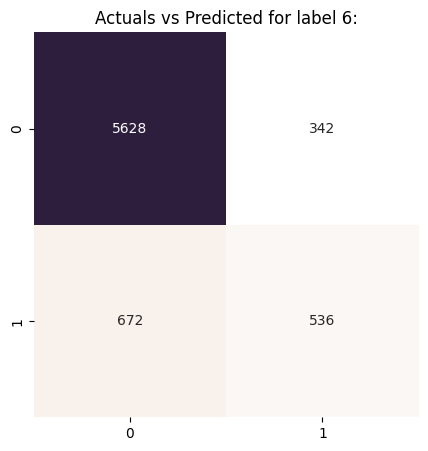

In [31]:
#Confusion matrix with seaborn
for i in range(len(cm)):
  print(f'Confusion matrix for label {i}:')
  print(cm[i])
  f, ax = plt.subplots(figsize=(5, 5))
  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(cm[i], cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
  plt.title(f'Actuals vs Predicted for label {i}:')
  plt.show()

In [32]:
#ROC

# Binarize
#def binarize(model, tr_features, te_features, y_train, y_test):
def binarize(model, tr_features, te_features, y_train, y_test, y_pred):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    #y_score = model.fit(tr_features, y_train).predict_generator(te_features)
    y_score = y_pred
    return y_onehot_test, y_score

# Plot ROC curve
def roc_curve(models, onehot_tests, scores):
    # plotting parameters
    cols = 3
    linewidth = 1
    pos_label = 0  # mean 0 belongs to positive class
    rows = math.ceil(7 / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows*6))
    model_names = {0:'CNN', 1:'RF', 2:'Ada'}

    for i in range(7):
        for m in range(len(models)):
            model_name = model_names[m]
            display = RocCurveDisplay.from_predictions(onehot_tests[m][:, i],
                                                       scores[m][:, i],
                                                       name=f"{model_name}",
                                                       linewidth=linewidth,
                                                       ax=axs[i // cols, i % cols],)

        axs[i // cols, i % cols].plot([0, 1], [0, 1], linewidth=linewidth, linestyle=":")
        axs[i // cols, i % cols].set_title(i)
        axs[i // cols, i % cols].set_xlabel("False Positive Rate")
        axs[i // cols, i % cols].set_ylabel("True Positive Rate")
    plt.tight_layout(pad=2.0)  # spacing between subplots
    plt.show()

In [33]:
#Run Binarizer
CNN_onehot, CNN_score = binarize(model, X_train, X_test, y_train, y_test, y_pred)

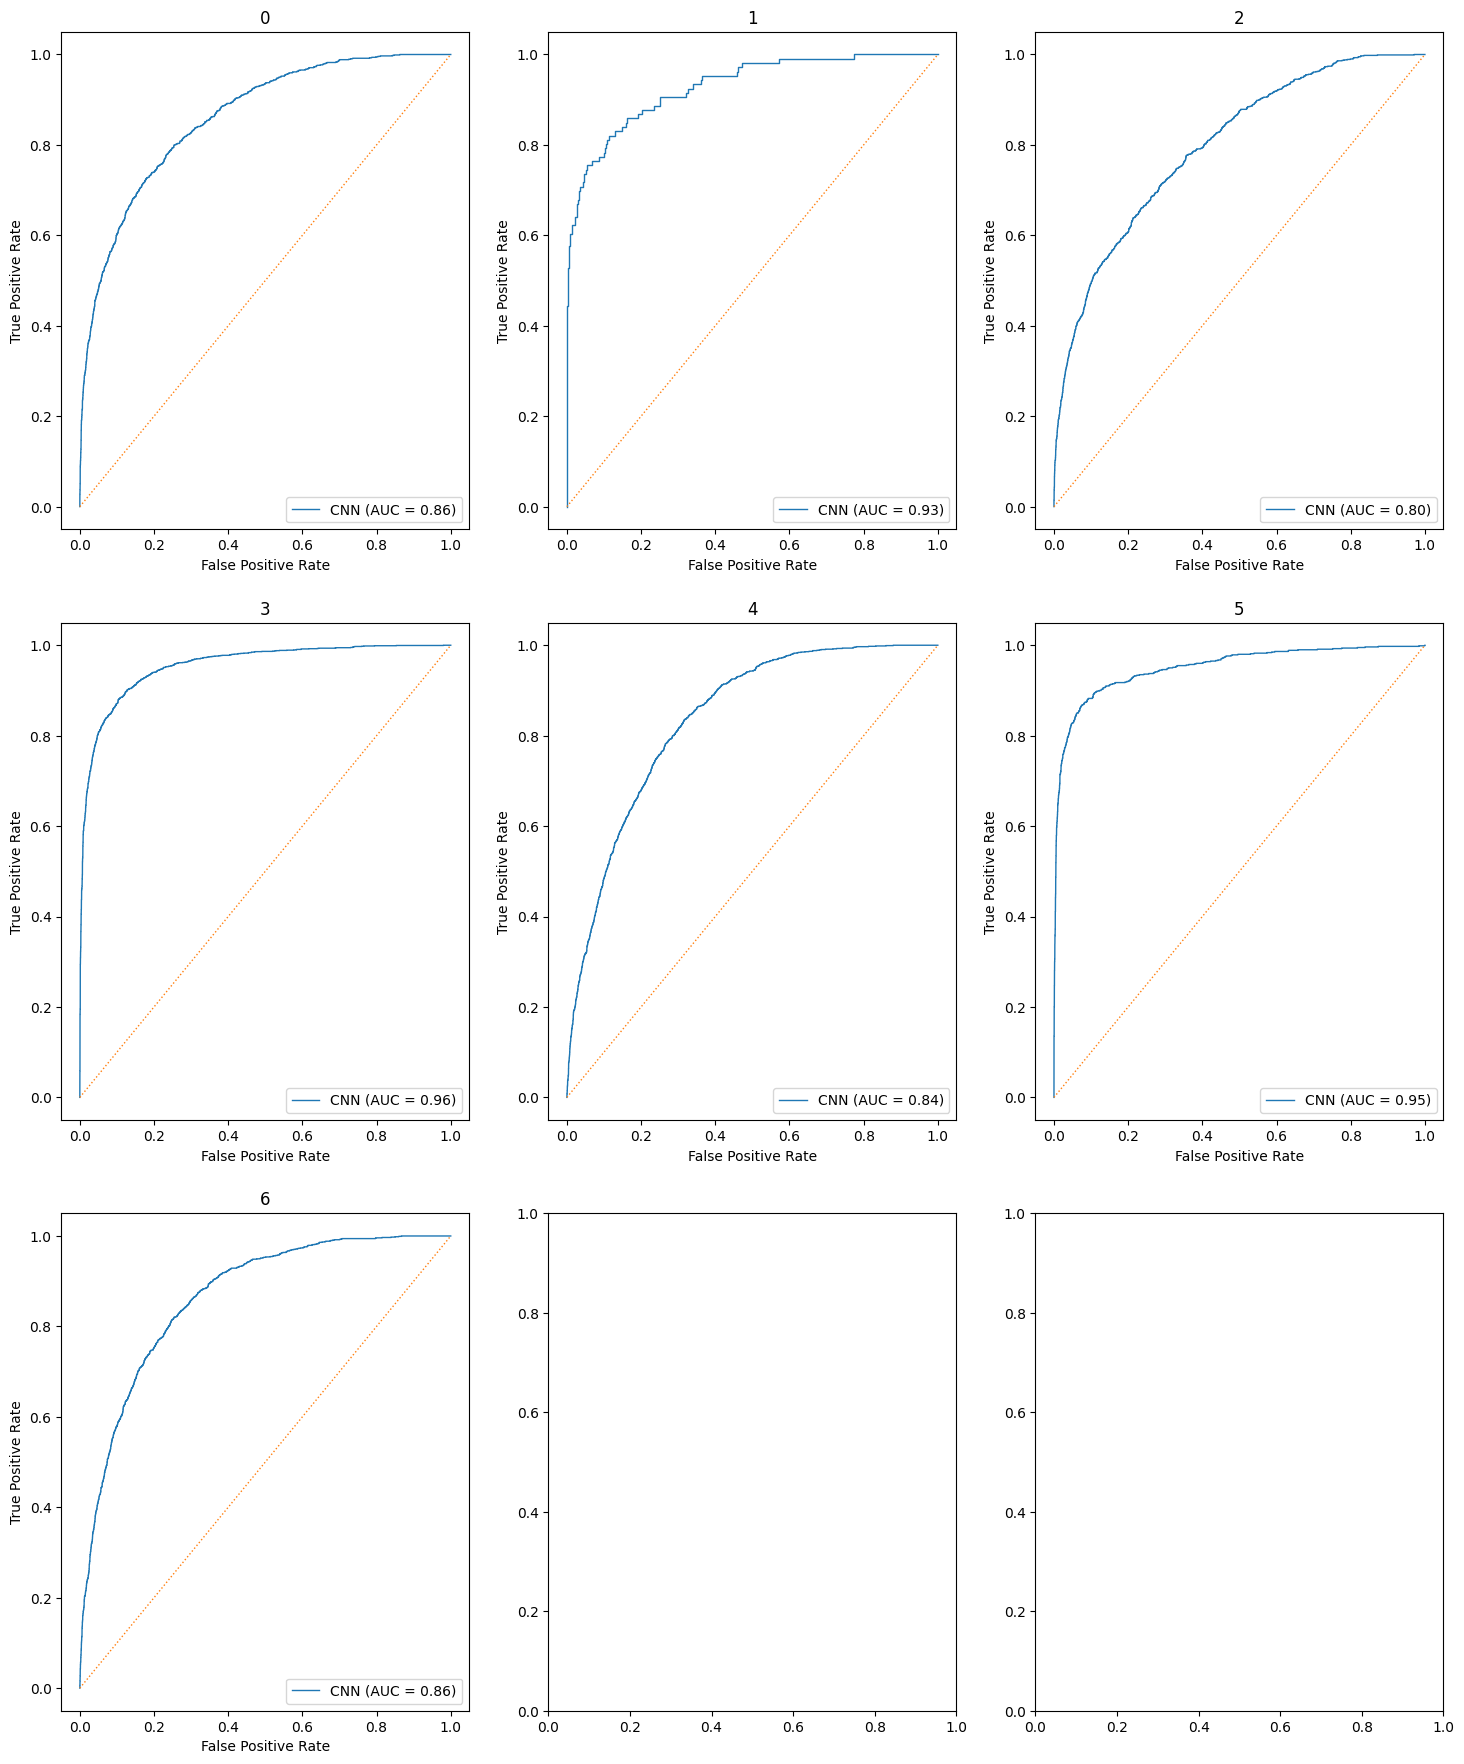

In [34]:
#ROC Curves
roc_curve([model], [CNN_onehot], [CNN_score])

In [35]:
#Average Precision, Recall, F1-measure
CNN_avg_precisionR = average_precision_score(y_test, y_pred_rounded)
CNN_recallR = recall_score(y_test, y_pred_rounded, average='weighted')
CNN_f1R = f1_score(y_test, y_pred_rounded, average='weighted')
print(f'Average precision for CNN: {CNN_avg_precisionR}')
print(f'Recall for CNN: {CNN_recallR}')
print(f'F1-measure for CNN: {CNN_f1R}')

Average precision for CNN: 0.44109761729924407
Recall for CNN: 0.5707718027305656
F1-measure for CNN: 0.6078113099437163
